In [24]:
import pyspark

In [25]:
# import necessary packages
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [26]:
sc = SparkContext()
# initiate the StreamingContext with 10 second batch interval. #next initiate sqlcontext
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [27]:
# initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)
# lines of tweets with socket_stream window of size 60, or 60 #seconds windows of time
lines = socket_stream.window(60)

In [28]:
# just a tuple to assign names
from collections import namedtuple
fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )
# here we apply different operations on the tweets and save them to #a temporary sql table
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  # Checks for    hashtag calls  
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) 
 # Stores in a Tweet Object
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
 # Sorts Them in a dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
 # Registers only top 10 hashtags to a table.
  .limit(10).registerTempTable("tweets") ) )

In [29]:
# start streaming and wait couple of minutes to get enought tweets
ssc.start()

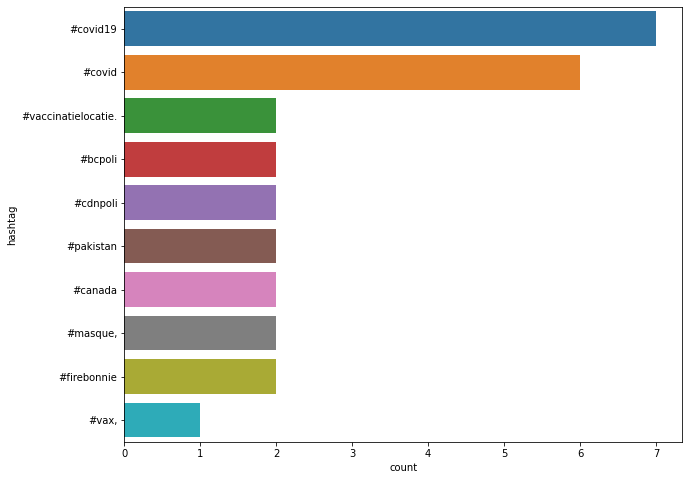

26


KeyboardInterrupt: 

In [33]:
# import libraries to visualize the results
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
get_ipython().run_line_magic('matplotlib', 'inline')
count = 0
while True:
    
    time.sleep(5)
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    count = count + 1
    print(count)

In [ ]:
ssc.stop()